<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/cifir10_cnn_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_size = len(trainset)
test_size = len(testset)
print('train size =', len(trainset), 'test size = ', len(testset))

Files already downloaded and verified
Files already downloaded and verified
train size = 50000 test size =  10000


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GPU搭載のCUDA環境を前提としており、その場合はcuda:0と出力されるはずです

print(device)

cuda:0


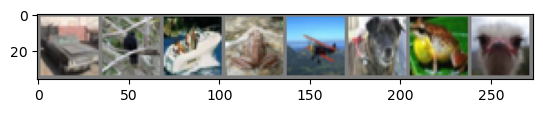

  car  bird  ship  frog plane   dog  frog  bird


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 画像の表示関数


def imshow(img):
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 適当な訓練セットの画像を取得
images, labels = next(iter(trainloader))

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
  for epoch in range(20):  # エポック数分ループを回します

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # データセットのデータを [inputs, labels]の形で取得
        inputs, labels = data[0].to(device), data[1].to(device)

        # パラメータの勾配をリセット
        optimizer.zero_grad()

        # 順伝搬＋逆伝搬＋パラメータ更新
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計情報の表示
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / train_size))

print('Finished Training')

[1] loss: 0.251
[2] loss: 0.209
[3] loss: 0.194
[4] loss: 0.184
[5] loss: 0.176
[6] loss: 0.170
[7] loss: 0.165
[8] loss: 0.160
[9] loss: 0.156
[10] loss: 0.152
[11] loss: 0.148
[12] loss: 0.145
[13] loss: 0.142
[14] loss: 0.139
[15] loss: 0.137
[16] loss: 0.135
[17] loss: 0.132
[18] loss: 0.130
[19] loss: 0.128
[20] loss: 0.126
Finished Training


In [11]:
PATH = './trained_models/CNN_cifar10_net.pth'
torch.save(net.state_dict(), PATH)

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

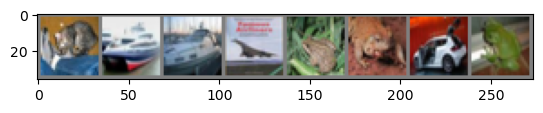

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog
Predicted:      dog  ship  ship plane  deer  frog   car  frog


In [14]:
data = next(iter(testloader))
images, labels = data[0].to(device), data[1].to(device)

# 画像と正解ラベルの表示
imshow(torchvision.utils.make_grid(images.to('cpu')))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

outputs = net(images).to('cpu')

_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))

In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device)).to('cpu')
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device)).to('cpu')
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 78 %
Accuracy of  bird : 61 %
Accuracy of   cat : 37 %
Accuracy of  deer : 57 %
Accuracy of   dog : 44 %
Accuracy of  frog : 69 %
Accuracy of horse : 62 %
Accuracy of  ship : 81 %
Accuracy of truck : 66 %


# Visualize the outputs of the trained

Each element of the output vectors is visualized as the histogram in which the target class and the other classes are with different colors

In [17]:
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    images, labels = data
    outputs = net(images.to(device)).cpu().numpy()
    if i == 0:
      outdata = np.array(outputs)
      outlabel = np.array(labels)
    else:
      outdata = np.append(outdata, outputs, axis=0)
      outlabel = np.append(outlabel, labels)
#    print(i, outdata.shape)
  print(outdata.shape)
  print(outlabel.shape)


(50000, 10)
(50000,)


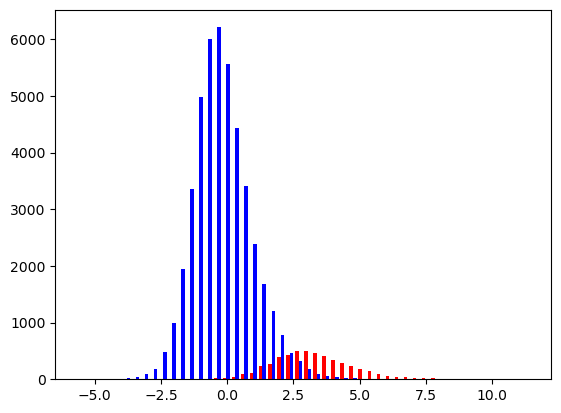

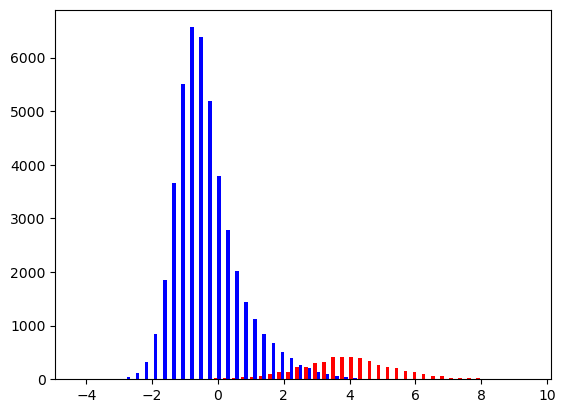

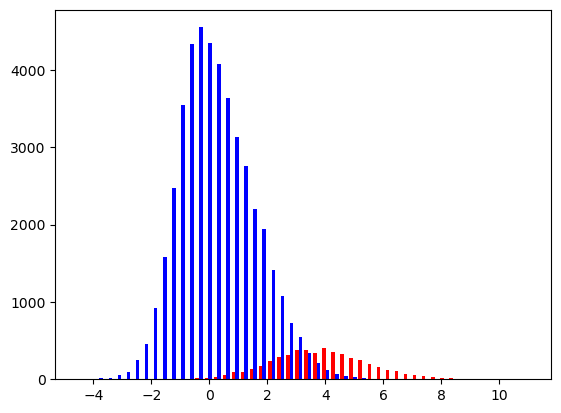

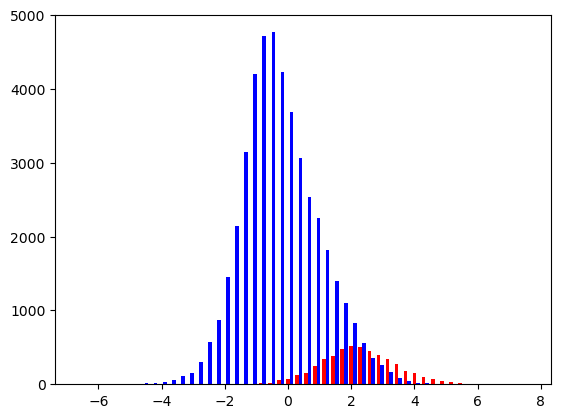

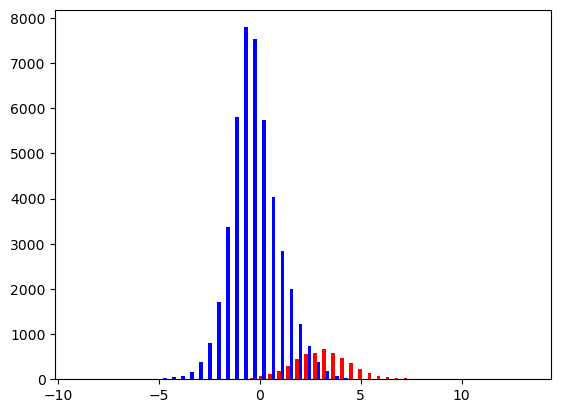

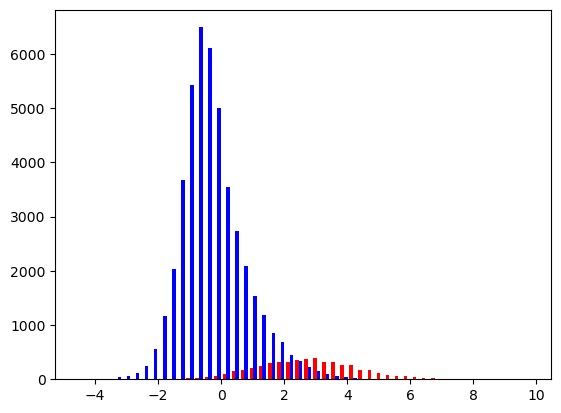

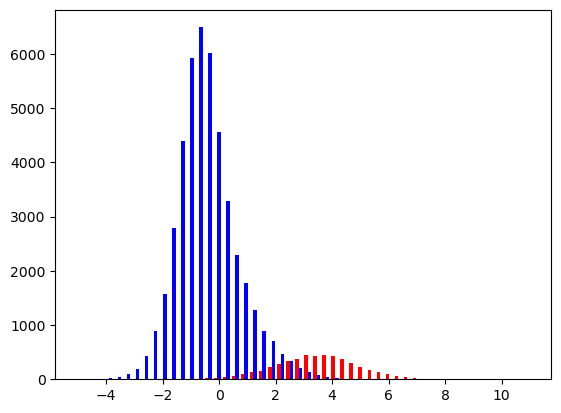

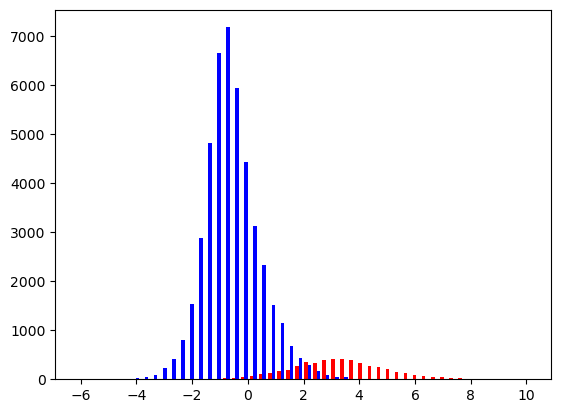

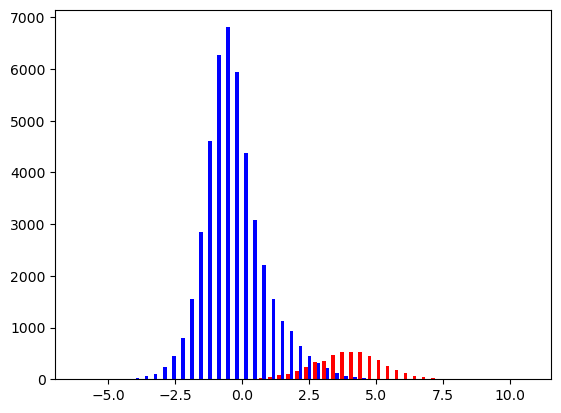

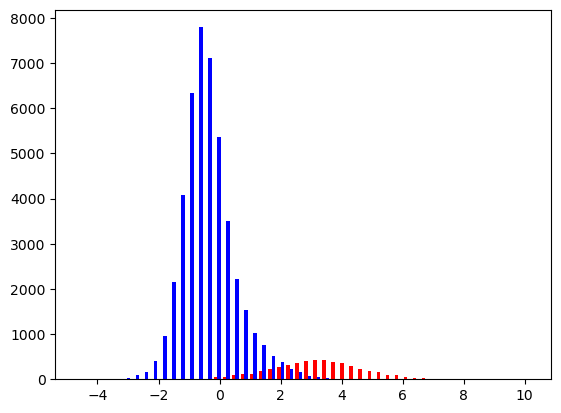

In [18]:
for k in range(10):
#  plt.hist([outdata[outlabel == k, k], outdata[outlabel != k, k]], bins=50, color=['cyan', 'Purple'])
  plt.hist([outdata[outlabel == k, k], outdata[outlabel != k, k]], bins=50, color=['red', 'blue'])
  plt.show()